In [1]:
import numpy as np
import pandas as pd 
from captum.attr import IntegratedGradients,NoiseTunnel,GradientShap,Occlusion
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

from fastai.vision.all import *
import albumentations
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
import json
import cv2

In [2]:
train_dir = 'C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/'


    
data_path_train = r'C:\Users\Steven\OneDrive - Cal State LA\Documents\train_metadata.json'
with open(data_path_train) as json_file:
    train_meta = json.load(json_file)
    
    
#loading json file for test data
data_path_test = r'C:\Users\Steven\OneDrive - Cal State LA\Documents\test_metadata.json'
with open(data_path_test) as json_file:
    meta_test = json.load(json_file) 

In [3]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)

train_df.head().style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,image_id,image_dir,category,genus
0,00000__001,C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__001.jpg,0,Abies
1,00000__002,C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__002.jpg,0,Abies
2,00000__003,C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__003.jpg,0,Abies
3,00000__004,C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__004.jpg,0,Abies
4,00000__005,C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__005.jpg,0,Abies


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839772 entries, 0 to 839771
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   image_id   839772 non-null  object
 1   image_dir  839772 non-null  object
 2   category   839772 non-null  int64 
 3   genus      839772 non-null  object
dtypes: int64(1), object(3)
memory usage: 25.6+ MB


In [5]:
train_df['category'].nunique()

15501

In [6]:
cat_val_cnt = train_df['category'].value_counts()
cat_val_cnt

2774     80
8854     80
12540    80
10805    80
12530    80
         ..
11108     6
488       6
14160     6
14456     5
13305     5
Name: category, Length: 15501, dtype: int64

In [7]:
cat_index = cat_val_cnt[cat_val_cnt == 80].sort_values(ascending=False).index
cat_index = cat_index[:20]

In [8]:
herb_train_df = train_df[train_df.category.isin(cat_index)]
herb_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 30737 to 689124
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   1600 non-null   object
 1   image_dir  1600 non-null   object
 2   category   1600 non-null   int64 
 3   genus      1600 non-null   object
dtypes: int64(1), object(3)
memory usage: 62.5+ KB


In [9]:
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")

In [10]:
def get_train_aug(): return albumentations.Compose([
#             albumentations.RandomResizedCrop(300,300),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

In [11]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [12]:
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug())]

C:\Users\Steven\anaasaonda\lib\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [13]:
splits = RandomSplitter(valid_pct=0.2)
dls = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                get_x=ColReader(1),
                get_y=ColReader(2),
                splitter  = splits,
                item_tfms=item_tfms).dataloaders(herb_train_df,bs=16)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


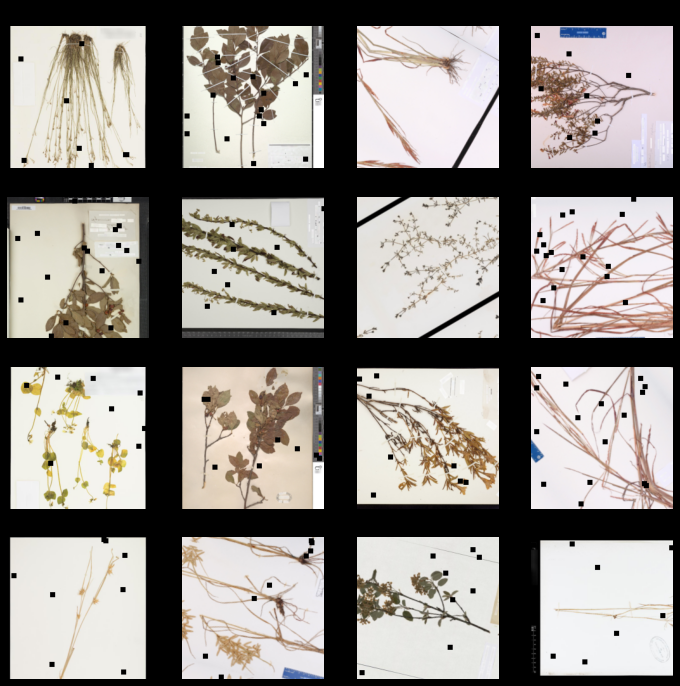

In [14]:
dls.show_batch(max_n=16)

In [15]:
learn = cnn_learner(dls, 
                    xresnet18, 
                    metrics=[accuracy, top_k_accuracy],
                    cbs = [EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=5),ActivationStats(with_hist=True)])

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to C:\Users\Steven/.cache\torch\hub\checkpoints\xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Ba

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
sr = learn.lr_find()
sr.valley

C:\Users\Steven\anaasaonda\lib\site-packages\fastai\callback\core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


In [ ]:
learn.fit_one_cycle(100,sr.valley)